In [1]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import optuna

# Data Prep

In [2]:
# class to create the dataset
class create_dataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=None, indices=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        self.label_mapping = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4} # Mapping of folder names to labels

        all_images = []
        all_labels = []


        # Loop through the folders and collect image paths and labels
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                label = self.label_mapping[folder]
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    all_images.append(file_path)
                    all_labels.append(label)

        # If max_images is specified, select a random subset
        if max_images is not None:
            indices = random.sample(range(len(all_images)), max_images)

        # If indices are specified, use them to select the subset
        if indices is not None:
            self.images = [all_images[i] for i in indices]
            self.labels = [all_labels[i] for i in indices]
        else:
            self.images = all_images
            self.labels = all_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Normalize pixel values

In [3]:
# Checking for GPU
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available.
Using device: cuda


In [4]:
# Splitting images 80/20
dataset = create_dataset('MedicalExpert-I', transform=transform) 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


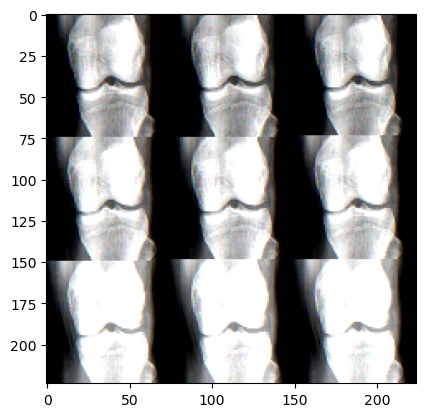

In [5]:
# Sample image from the dataset
train_iter = iter(train_dataset)
images, labels = next(train_iter)
np_image = images.numpy()
plt.imshow(np_image.reshape(224, 224, 3))

# CNN

In [7]:
# Creating CNN model
class CNN(nn.Module):
    def __init__(self, trial, num_classes=5):
        super(CNN, self).__init__()
        # Suggest the number of filters in the convolutional layers
        self.n_filters_conv1 = trial.suggest_categorical('n_filters_conv1', [16, 32, 64])
        self.n_filters_conv2 = trial.suggest_categorical('n_filters_conv2', [32, 64, 128])
        self.n_units_fc1 = trial.suggest_categorical('n_units_fc1', [256, 512, 1024])

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n_filters_conv1, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.n_filters_conv1)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=self.n_filters_conv1, out_channels=self.n_filters_conv2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.n_filters_conv2)  # Batch Normalization after conv2
        self.fc1 = nn.Linear(self.n_filters_conv2 * 56 * 56, self.n_units_fc1)  
        self.fc2 = nn.Linear(self.n_units_fc1, num_classes)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, self.n_filters_conv2 * 56 * 56)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
# Optuna optimization
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Stop training if the loss does not improve for 10 epochs
    patience = 5  
    best_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            # Compute the number of correct predictions
            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            # Compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute the average loss and overall accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation to save memory
    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute the accuracy
            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        # Print the average accuracy and loss for the validation set
        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [9]:
# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-04-29 13:44:52,383] A new study created in memory with name: no-name-3ef4eb70-b649-4ddd-9682-df107d869182
/tmp/ipykernel_10097/3272318722.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Epoch 1/40, Loss: 5.5994, Accuracy: 0.2583
Epoch 2/40, Loss: 1.5903, Accuracy: 0.3000
Epoch 3/40, Loss: 1.5089, Accuracy: 0.3242
Epoch 4/40, Loss: 1.5051, Accuracy: 0.3250
Epoch 5/40, Loss: 1.4503, Accuracy: 0.3500
Epoch 6/40, Loss: 1.4491, Accuracy: 0.3652
Epoch 7/40, Loss: 1.4267, Accuracy: 0.3765
Epoch 8/40, Loss: 1.3997, Accuracy: 0.3864
Epoch 9/40, Loss: 1.3893, Accuracy: 0.3970
Epoch 10/40, Loss: 1.3768, Accuracy: 0.3992
Epoch 11/40, Loss: 1.3672, Accuracy: 0.4114
Epoch 12/40, Loss: 1.3683, Accuracy: 0.4129
Epoch 13/40, Loss: 1.3609, Accuracy: 0.4182
Epoch 14/40, Loss: 1.3429, Accuracy: 0.4212
Epoch 15/40, Loss: 1.3125, Accuracy: 0.4515
Epoch 16/40, Loss: 1.3101, Accuracy: 0.4455
Epoch 17/40, Loss: 1.3057, Accuracy: 0.4318
Epoch 18/40, Loss: 1.2936, Accuracy: 0.4402
Epoch 19/40, Loss: 1.2714, Accuracy: 0.4591
Epoch 20/40, Loss: 1.2648, Accuracy: 0.4485
Epoch 21/40, Loss: 1.2421, Accuracy: 0.4636
Epoch 22/40, Loss: 1.2641, Accuracy: 0.4644
Epoch 23/40, Loss: 1.2143, Accuracy: 0.48

[I 2024-04-29 13:47:41,767] Trial 0 finished with value: 0.531547619047619 and parameters: {'lr': 0.0004298400564630166, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 64, 'n_filters_conv2': 64, 'n_units_fc1': 512}. Best is trial 0 with value: 0.531547619047619.


Validation accuracy: 0.5315, Validation loss: 1.3492
Epoch 1/40, Loss: 1.5606, Accuracy: 0.2977
Epoch 2/40, Loss: 1.5146, Accuracy: 0.3205
Epoch 3/40, Loss: 1.4764, Accuracy: 0.3500
Epoch 4/40, Loss: 1.4581, Accuracy: 0.3606
Epoch 5/40, Loss: 1.4447, Accuracy: 0.3758
Epoch 6/40, Loss: 1.4141, Accuracy: 0.4000
Epoch 7/40, Loss: 1.4114, Accuracy: 0.3780
Epoch 8/40, Loss: 1.4020, Accuracy: 0.3856
Epoch 9/40, Loss: 1.3922, Accuracy: 0.3955
Epoch 10/40, Loss: 1.3673, Accuracy: 0.4000
Epoch 11/40, Loss: 1.3522, Accuracy: 0.4197
Epoch 12/40, Loss: 1.3079, Accuracy: 0.4538
Epoch 13/40, Loss: 1.2901, Accuracy: 0.4811
Epoch 14/40, Loss: 1.2934, Accuracy: 0.4455
Epoch 15/40, Loss: 1.2756, Accuracy: 0.4553
Epoch 16/40, Loss: 1.2421, Accuracy: 0.4871
Epoch 17/40, Loss: 1.2357, Accuracy: 0.4894
Epoch 18/40, Loss: 1.2566, Accuracy: 0.4742
Epoch 19/40, Loss: 1.2131, Accuracy: 0.4894
Epoch 20/40, Loss: 1.2088, Accuracy: 0.4909
Epoch 21/40, Loss: 1.2107, Accuracy: 0.5068
Epoch 22/40, Loss: 1.1881, Accur

[I 2024-04-29 13:49:47,461] Trial 1 finished with value: 0.5401041666666667 and parameters: {'lr': 0.0017913266106068337, 'batch_size': 64, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 32, 'n_units_fc1': 512}. Best is trial 1 with value: 0.5401041666666667.


Validation accuracy: 0.5401, Validation loss: 1.1978
Epoch 1/40, Loss: 7.0040, Accuracy: 0.2629
Epoch 2/40, Loss: 1.7586, Accuracy: 0.3235
Epoch 3/40, Loss: 1.6080, Accuracy: 0.3447
Epoch 4/40, Loss: 1.5630, Accuracy: 0.3659
Epoch 5/40, Loss: 1.5141, Accuracy: 0.3803
Epoch 6/40, Loss: 1.4670, Accuracy: 0.3955
Epoch 7/40, Loss: 1.3885, Accuracy: 0.4273
Epoch 8/40, Loss: 1.3409, Accuracy: 0.4530
Epoch 9/40, Loss: 1.3482, Accuracy: 0.4371
Epoch 10/40, Loss: 1.2726, Accuracy: 0.4720
Epoch 11/40, Loss: 1.2153, Accuracy: 0.4833
Epoch 12/40, Loss: 1.1493, Accuracy: 0.5530
Epoch 13/40, Loss: 1.1154, Accuracy: 0.5545
Epoch 14/40, Loss: 1.0717, Accuracy: 0.5826
Epoch 15/40, Loss: 0.9945, Accuracy: 0.6152
Epoch 16/40, Loss: 0.9491, Accuracy: 0.6205
Epoch 17/40, Loss: 0.8958, Accuracy: 0.6606
Epoch 18/40, Loss: 0.8363, Accuracy: 0.6667
Epoch 19/40, Loss: 0.8225, Accuracy: 0.6780
Epoch 20/40, Loss: 0.7298, Accuracy: 0.7235
Epoch 21/40, Loss: 0.6855, Accuracy: 0.7386
Epoch 22/40, Loss: 0.6053, Accur

[I 2024-04-29 13:52:26,334] Trial 2 finished with value: 0.5654761904761905 and parameters: {'lr': 0.0001760892890239117, 'batch_size': 8, 'optimizer': 'RMSprop', 'n_filters_conv1': 16, 'n_filters_conv2': 32, 'n_units_fc1': 1024}. Best is trial 2 with value: 0.5654761904761905.


Validation accuracy: 0.5655, Validation loss: 2.0691
Epoch 1/40, Loss: 1.5472, Accuracy: 0.2879
Epoch 2/40, Loss: 1.5162, Accuracy: 0.3015
Epoch 3/40, Loss: 1.5089, Accuracy: 0.3235
Epoch 4/40, Loss: 1.4943, Accuracy: 0.3348
Epoch 5/40, Loss: 1.4806, Accuracy: 0.3402
Epoch 6/40, Loss: 1.4531, Accuracy: 0.3689
Epoch 7/40, Loss: 1.4497, Accuracy: 0.3674
Epoch 8/40, Loss: 1.4527, Accuracy: 0.3659
Epoch 9/40, Loss: 1.4263, Accuracy: 0.3773
Epoch 10/40, Loss: 1.4221, Accuracy: 0.3871
Epoch 11/40, Loss: 1.4144, Accuracy: 0.3803
Epoch 12/40, Loss: 1.3968, Accuracy: 0.3977
Epoch 13/40, Loss: 1.3987, Accuracy: 0.3947
Epoch 14/40, Loss: 1.3706, Accuracy: 0.4045
Epoch 15/40, Loss: 1.3540, Accuracy: 0.4197
Epoch 16/40, Loss: 1.3519, Accuracy: 0.4076
Epoch 17/40, Loss: 1.3301, Accuracy: 0.4356
Epoch 18/40, Loss: 1.3413, Accuracy: 0.4341
Epoch 19/40, Loss: 1.3122, Accuracy: 0.4561
Epoch 20/40, Loss: 1.3059, Accuracy: 0.4508
Epoch 21/40, Loss: 1.3108, Accuracy: 0.4379
Epoch 22/40, Loss: 1.2907, Accur

[I 2024-04-29 13:54:57,528] Trial 3 finished with value: 0.5208333333333334 and parameters: {'lr': 3.821583997946975e-05, 'batch_size': 8, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 64, 'n_units_fc1': 512}. Best is trial 2 with value: 0.5654761904761905.


Validation accuracy: 0.5208, Validation loss: 1.1872
Epoch 1/40, Loss: 2.0254, Accuracy: 0.2894
Epoch 2/40, Loss: 1.4987, Accuracy: 0.3318
Epoch 3/40, Loss: 1.4561, Accuracy: 0.3598
Epoch 4/40, Loss: 1.4276, Accuracy: 0.3803
Epoch 5/40, Loss: 1.3965, Accuracy: 0.4106
Epoch 6/40, Loss: 1.3465, Accuracy: 0.4068
Epoch 7/40, Loss: 1.2586, Accuracy: 0.4720
Epoch 8/40, Loss: 1.2221, Accuracy: 0.4894
Epoch 9/40, Loss: 1.1966, Accuracy: 0.5023
Epoch 10/40, Loss: 1.1266, Accuracy: 0.5303
Epoch 11/40, Loss: 1.0964, Accuracy: 0.5492
Epoch 12/40, Loss: 1.0912, Accuracy: 0.5659
Epoch 13/40, Loss: 1.0218, Accuracy: 0.6008
Epoch 14/40, Loss: 0.9841, Accuracy: 0.6030
Epoch 15/40, Loss: 0.9249, Accuracy: 0.6348
Epoch 16/40, Loss: 0.9023, Accuracy: 0.6371
Epoch 17/40, Loss: 0.8333, Accuracy: 0.6795
Epoch 18/40, Loss: 0.8199, Accuracy: 0.6795
Epoch 19/40, Loss: 0.7796, Accuracy: 0.6871
Epoch 20/40, Loss: 0.7287, Accuracy: 0.7280
Epoch 21/40, Loss: 0.7002, Accuracy: 0.7348
Epoch 22/40, Loss: 0.6608, Accur

[I 2024-04-29 13:58:23,283] Trial 4 finished with value: 0.594047619047619 and parameters: {'lr': 4.5062425881568946e-05, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 64, 'n_filters_conv2': 64, 'n_units_fc1': 1024}. Best is trial 4 with value: 0.594047619047619.


Validation accuracy: 0.5940, Validation loss: 1.4120
Epoch 1/40, Loss: 2.6624, Accuracy: 0.2583
Epoch 2/40, Loss: 1.6266, Accuracy: 0.3220
Epoch 3/40, Loss: 1.5365, Accuracy: 0.3553
Epoch 4/40, Loss: 1.4873, Accuracy: 0.3682
Epoch 5/40, Loss: 1.4263, Accuracy: 0.3871
Epoch 6/40, Loss: 1.4103, Accuracy: 0.3886
Epoch 7/40, Loss: 1.3182, Accuracy: 0.4485
Epoch 8/40, Loss: 1.3456, Accuracy: 0.4538
Epoch 9/40, Loss: 1.2945, Accuracy: 0.4682
Epoch 10/40, Loss: 1.2041, Accuracy: 0.5091
Epoch 11/40, Loss: 1.2036, Accuracy: 0.5144
Epoch 12/40, Loss: 1.1533, Accuracy: 0.5197
Epoch 13/40, Loss: 1.1417, Accuracy: 0.5379
Epoch 14/40, Loss: 1.0905, Accuracy: 0.5652
Epoch 15/40, Loss: 1.0674, Accuracy: 0.5659
Epoch 16/40, Loss: 1.0207, Accuracy: 0.5992
Epoch 17/40, Loss: 0.9896, Accuracy: 0.5947
Epoch 18/40, Loss: 0.9538, Accuracy: 0.6250
Epoch 19/40, Loss: 0.9216, Accuracy: 0.6409
Epoch 20/40, Loss: 0.8744, Accuracy: 0.6515
Epoch 21/40, Loss: 0.8396, Accuracy: 0.6894
Epoch 22/40, Loss: 0.8189, Accur

[I 2024-04-29 14:01:13,574] Trial 5 finished with value: 0.6041666666666666 and parameters: {'lr': 3.3713009563984106e-05, 'batch_size': 8, 'optimizer': 'RMSprop', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 512}. Best is trial 5 with value: 0.6041666666666666.


Validation accuracy: 0.6042, Validation loss: 1.2620
Epoch 1/40, Loss: 263.1683, Accuracy: 0.1955
Epoch 2/40, Loss: 1.7446, Accuracy: 0.2689
Epoch 3/40, Loss: 1.7138, Accuracy: 0.3053
Epoch 4/40, Loss: 1.6088, Accuracy: 0.3053
Epoch 5/40, Loss: 1.6012, Accuracy: 0.3053
Epoch 6/40, Loss: 1.6347, Accuracy: 0.2992
Epoch 7/40, Loss: 1.5653, Accuracy: 0.3038
Epoch 8/40, Loss: 1.6029, Accuracy: 0.3023
Epoch 9/40, Loss: 1.5509, Accuracy: 0.3053
Epoch 10/40, Loss: 1.5457, Accuracy: 0.3038
Epoch 11/40, Loss: 1.5399, Accuracy: 0.3053
Epoch 12/40, Loss: 1.5390, Accuracy: 0.3015
Epoch 13/40, Loss: 1.5453, Accuracy: 0.3076
Epoch 14/40, Loss: 1.5534, Accuracy: 0.3030
Epoch 15/40, Loss: 1.5482, Accuracy: 0.3023
Epoch 16/40, Loss: 1.5680, Accuracy: 0.3038
Epoch 17/40, Loss: 1.5307, Accuracy: 0.3038
Epoch 18/40, Loss: 1.6078, Accuracy: 0.3045
Epoch 19/40, Loss: 1.5385, Accuracy: 0.3038
Epoch 20/40, Loss: 1.5449, Accuracy: 0.3038
Epoch 21/40, Loss: 1.7060, Accuracy: 0.3061
Epoch 22/40, Loss: 1.5586, Acc

[I 2024-04-29 14:02:31,386] Trial 6 finished with value: 0.34602272727272726 and parameters: {'lr': 0.00155824540244343, 'batch_size': 32, 'optimizer': 'RMSprop', 'n_filters_conv1': 16, 'n_filters_conv2': 128, 'n_units_fc1': 512}. Best is trial 5 with value: 0.6041666666666666.


Validation accuracy: 0.3460, Validation loss: 1.5008
Epoch 1/40, Loss: 10.3821, Accuracy: 0.2773
Epoch 2/40, Loss: 1.6334, Accuracy: 0.2924
Epoch 3/40, Loss: 1.5907, Accuracy: 0.2902
Epoch 4/40, Loss: 1.5753, Accuracy: 0.2803
Epoch 5/40, Loss: 1.5981, Accuracy: 0.3114
Epoch 6/40, Loss: 1.5705, Accuracy: 0.3045
Epoch 7/40, Loss: 1.5921, Accuracy: 0.3015
Epoch 8/40, Loss: 1.5663, Accuracy: 0.3023
Epoch 9/40, Loss: 1.5480, Accuracy: 0.3061
Epoch 10/40, Loss: 1.5458, Accuracy: 0.3061
Epoch 11/40, Loss: 1.5376, Accuracy: 0.3076
Epoch 12/40, Loss: 1.5393, Accuracy: 0.3023
Epoch 13/40, Loss: 1.5481, Accuracy: 0.3030
Epoch 14/40, Loss: 1.5449, Accuracy: 0.3038
Epoch 15/40, Loss: 1.5655, Accuracy: 0.3061
Epoch 16/40, Loss: 1.5442, Accuracy: 0.3053
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:03:37,886] Trial 7 finished with value: 0.34345238095238095 and parameters: {'lr': 0.0010281547967166012, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 64, 'n_filters_conv2': 64, 'n_units_fc1': 512}. Best is trial 5 with value: 0.6041666666666666.


Validation accuracy: 0.3435, Validation loss: 1.5067
Epoch 1/40, Loss: 92.4857, Accuracy: 0.2591
Epoch 2/40, Loss: 1.6853, Accuracy: 0.3068
Epoch 3/40, Loss: 1.7667, Accuracy: 0.3076
Epoch 4/40, Loss: 1.5827, Accuracy: 0.3030
Epoch 5/40, Loss: 1.6168, Accuracy: 0.3068
Epoch 6/40, Loss: 1.5802, Accuracy: 0.3023
Epoch 7/40, Loss: 1.5506, Accuracy: 0.3038
Epoch 8/40, Loss: 1.5396, Accuracy: 0.3023
Epoch 9/40, Loss: 1.5389, Accuracy: 0.3045
Epoch 10/40, Loss: 1.5374, Accuracy: 0.3038
Epoch 11/40, Loss: 1.5397, Accuracy: 0.3023
Epoch 12/40, Loss: 1.5743, Accuracy: 0.3038
Epoch 13/40, Loss: 1.5348, Accuracy: 0.3038
Epoch 14/40, Loss: 1.5423, Accuracy: 0.3038
Epoch 15/40, Loss: 1.5391, Accuracy: 0.3030
Epoch 16/40, Loss: 1.5341, Accuracy: 0.3038
Epoch 17/40, Loss: 1.5333, Accuracy: 0.3030
Epoch 18/40, Loss: 1.5340, Accuracy: 0.3030
Epoch 19/40, Loss: 1.5650, Accuracy: 0.3045
Epoch 20/40, Loss: 1.5367, Accuracy: 0.3038
Epoch 21/40, Loss: 1.5347, Accuracy: 0.3038
Epoch 22/40, Loss: 1.5341, Accu

[I 2024-04-29 14:05:10,614] Trial 8 finished with value: 0.34345238095238095 and parameters: {'lr': 0.0016069280405806331, 'batch_size': 16, 'optimizer': 'RMSprop', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 256}. Best is trial 5 with value: 0.6041666666666666.


Validation accuracy: 0.3435, Validation loss: 1.5030
Epoch 1/40, Loss: 2.1354, Accuracy: 0.2818
Epoch 2/40, Loss: 1.5328, Accuracy: 0.3182
Epoch 3/40, Loss: 1.4999, Accuracy: 0.3174
Epoch 4/40, Loss: 1.4556, Accuracy: 0.3636
Epoch 5/40, Loss: 1.4317, Accuracy: 0.3652
Epoch 6/40, Loss: 1.3383, Accuracy: 0.4235
Epoch 7/40, Loss: 1.3311, Accuracy: 0.4235
Epoch 8/40, Loss: 1.2852, Accuracy: 0.4606
Epoch 9/40, Loss: 1.2533, Accuracy: 0.4500
Epoch 10/40, Loss: 1.2148, Accuracy: 0.4848
Epoch 11/40, Loss: 1.1894, Accuracy: 0.5152
Epoch 12/40, Loss: 1.1606, Accuracy: 0.5333
Epoch 13/40, Loss: 1.1122, Accuracy: 0.5348
Epoch 14/40, Loss: 1.0849, Accuracy: 0.5705
Epoch 15/40, Loss: 1.0515, Accuracy: 0.5758
Epoch 16/40, Loss: 1.0068, Accuracy: 0.6008
Epoch 17/40, Loss: 0.9959, Accuracy: 0.5879
Epoch 18/40, Loss: 0.9357, Accuracy: 0.6462
Epoch 19/40, Loss: 0.8853, Accuracy: 0.6667
Epoch 20/40, Loss: 0.8654, Accuracy: 0.6629
Epoch 21/40, Loss: 0.8397, Accuracy: 0.6606
Epoch 22/40, Loss: 0.7810, Accur

[I 2024-04-29 14:07:38,486] Trial 9 finished with value: 0.5666666666666667 and parameters: {'lr': 7.098320586466842e-05, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 512}. Best is trial 5 with value: 0.6041666666666666.


Validation accuracy: 0.5667, Validation loss: 1.1893


In [10]:
# Print the best hyperparameters
print(study.best_params)

{'lr': 3.3713009563984106e-05, 'batch_size': 8, 'optimizer': 'RMSprop', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 512}


In [11]:
best_params = study.best_params

# New model with the best parameters
class bestCNN(nn.Module):
    def __init__(self, best_params):
        super(bestCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=best_params['n_filters_conv1'], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(best_params['n_filters_conv1'])  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=best_params['n_filters_conv1'], out_channels=best_params['n_filters_conv2'], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(best_params['n_filters_conv2'])  # Batch Normalization after conv2
        self.fc1 = nn.Linear(best_params['n_filters_conv2'] * 56 * 56, best_params['n_units_fc1'])  # Adjust 56 * 56 based on the input image size
        self.fc2 = nn.Linear(best_params['n_units_fc1'], 5)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, best_params['n_filters_conv2'] * 56 * 56)  # Adjust 56 * 56 based on the input image size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use the parameters in the model/optimizer
model = bestCNN(best_params).to(device)

In [12]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [13]:
# Training loop
patience = 5
best_loss = float('inf')  
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

Epoch 1/40, Loss: 3.0180, Accuracy: 0.2939
Epoch 2/40, Loss: 1.7286, Accuracy: 0.3220
Epoch 3/40, Loss: 1.5764, Accuracy: 0.3917
Epoch 4/40, Loss: 1.5446, Accuracy: 0.3803
Epoch 5/40, Loss: 1.4769, Accuracy: 0.4061
Epoch 6/40, Loss: 1.4233, Accuracy: 0.4318
Epoch 7/40, Loss: 1.3861, Accuracy: 0.4530
Epoch 8/40, Loss: 1.3379, Accuracy: 0.4553
Epoch 9/40, Loss: 1.2981, Accuracy: 0.4712
Epoch 10/40, Loss: 1.2404, Accuracy: 0.4871
Epoch 11/40, Loss: 1.2263, Accuracy: 0.5068
Epoch 12/40, Loss: 1.1882, Accuracy: 0.5227
Epoch 13/40, Loss: 1.1303, Accuracy: 0.5348
Epoch 14/40, Loss: 1.1205, Accuracy: 0.5500
Epoch 15/40, Loss: 1.1018, Accuracy: 0.5583
Epoch 16/40, Loss: 1.0498, Accuracy: 0.5826
Epoch 17/40, Loss: 1.0266, Accuracy: 0.5856
Epoch 18/40, Loss: 1.0205, Accuracy: 0.6121
Epoch 19/40, Loss: 1.0068, Accuracy: 0.6091
Epoch 20/40, Loss: 0.9341, Accuracy: 0.6379
Epoch 21/40, Loss: 0.9111, Accuracy: 0.6515
Epoch 22/40, Loss: 0.8850, Accuracy: 0.6659
Epoch 23/40, Loss: 0.8290, Accuracy: 0.68

# VGG19

In [14]:
class VGG19(nn.Module):
    def __init__(self, trial):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True) # Freeze the pre-trained layers
        for param in self.vgg19.features.parameters():
            param.requires_grad = False
        num_classes = 5  
        self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.vgg19(x)

In [15]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = VGG19(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf')  # Best loss achieved so far
    wait = 0  

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [16]:
vgg19 = optuna.create_study(direction='maximize')
vgg19.optimize(objective, n_trials=10)

[I 2024-04-29 14:10:31,670] A new study created in memory with name: no-name-ecce77e5-a422-46a6-b264-1940828115f7
/tmp/ipykernel_10097/729569156.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/home/bengy/miniforge3/envs/cuda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bengy/miniforge3/envs/cuda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights

Epoch 1/40, Loss: 1.5791, Accuracy: 0.2788
Epoch 2/40, Loss: 1.5567, Accuracy: 0.3280
Epoch 3/40, Loss: 1.4932, Accuracy: 0.3394
Epoch 4/40, Loss: 1.4560, Accuracy: 0.3515
Epoch 5/40, Loss: 1.4125, Accuracy: 0.3811
Epoch 6/40, Loss: 1.3814, Accuracy: 0.4068
Epoch 7/40, Loss: 1.3679, Accuracy: 0.4167
Epoch 8/40, Loss: 1.3152, Accuracy: 0.4508
Epoch 9/40, Loss: 1.3105, Accuracy: 0.4500
Epoch 10/40, Loss: 1.2987, Accuracy: 0.4583
Epoch 11/40, Loss: 1.2802, Accuracy: 0.4871
Epoch 12/40, Loss: 1.2539, Accuracy: 0.4727
Epoch 13/40, Loss: 1.2214, Accuracy: 0.4932
Epoch 14/40, Loss: 1.2215, Accuracy: 0.4871
Epoch 15/40, Loss: 1.2026, Accuracy: 0.5129
Epoch 16/40, Loss: 1.1929, Accuracy: 0.5091
Epoch 17/40, Loss: 1.1982, Accuracy: 0.5091
Epoch 18/40, Loss: 1.1597, Accuracy: 0.5197
Epoch 19/40, Loss: 1.1592, Accuracy: 0.5250
Epoch 20/40, Loss: 1.1465, Accuracy: 0.5242
Epoch 21/40, Loss: 1.1247, Accuracy: 0.5371
Epoch 22/40, Loss: 1.1219, Accuracy: 0.5432
Epoch 23/40, Loss: 1.1226, Accuracy: 0.54

[I 2024-04-29 14:13:31,857] Trial 0 finished with value: 0.6664772727272728 and parameters: {'lr': 0.0003670042585949542, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6664772727272728.


Validation accuracy: 0.6665, Validation loss: 0.9145
Epoch 1/40, Loss: 25.7684, Accuracy: 0.2689
Epoch 2/40, Loss: 3.6056, Accuracy: 0.3780
Epoch 3/40, Loss: 5.5409, Accuracy: 0.3924
Epoch 4/40, Loss: 4.2960, Accuracy: 0.3553
Epoch 5/40, Loss: 2.8749, Accuracy: 0.3424
Epoch 6/40, Loss: 4.1791, Accuracy: 0.3386
Epoch 7/40, Loss: 4.2538, Accuracy: 0.2909
Epoch 8/40, Loss: 3.4116, Accuracy: 0.2924
Epoch 9/40, Loss: 2.4070, Accuracy: 0.3205
Epoch 10/40, Loss: 1.9267, Accuracy: 0.3242
Epoch 11/40, Loss: 1.6253, Accuracy: 0.3333
Epoch 12/40, Loss: 1.5487, Accuracy: 0.2985
Epoch 13/40, Loss: 1.6797, Accuracy: 0.3159
Epoch 14/40, Loss: 1.6235, Accuracy: 0.3356
Epoch 15/40, Loss: 1.8052, Accuracy: 0.3144
Epoch 16/40, Loss: 1.5606, Accuracy: 0.2955
Epoch 17/40, Loss: 1.7404, Accuracy: 0.3159
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:14:58,342] Trial 1 finished with value: 0.3630681818181818 and parameters: {'lr': 0.005629313933845248, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6664772727272728.


Validation accuracy: 0.3631, Validation loss: 2.2371
Epoch 1/40, Loss: 3.1261, Accuracy: 0.2598
Epoch 2/40, Loss: 1.4795, Accuracy: 0.3447
Epoch 3/40, Loss: 1.1883, Accuracy: 0.4780
Epoch 4/40, Loss: 1.0718, Accuracy: 0.5492
Epoch 5/40, Loss: 0.9577, Accuracy: 0.6144
Epoch 6/40, Loss: 0.8574, Accuracy: 0.6591
Epoch 7/40, Loss: 0.7232, Accuracy: 0.7076
Epoch 8/40, Loss: 0.6148, Accuracy: 0.7659
Epoch 9/40, Loss: 0.6382, Accuracy: 0.7773
Epoch 10/40, Loss: 0.5456, Accuracy: 0.8068
Epoch 11/40, Loss: 0.5885, Accuracy: 0.8189
Epoch 12/40, Loss: 0.5827, Accuracy: 0.8167
Epoch 13/40, Loss: 0.5889, Accuracy: 0.8394
Epoch 14/40, Loss: 0.4904, Accuracy: 0.8614
Epoch 15/40, Loss: 0.5553, Accuracy: 0.8508
Epoch 16/40, Loss: 0.7311, Accuracy: 0.8508
Epoch 17/40, Loss: 0.6586, Accuracy: 0.8674
Epoch 18/40, Loss: 0.6274, Accuracy: 0.8553
Epoch 19/40, Loss: 0.5593, Accuracy: 0.8750
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:16:28,349] Trial 2 finished with value: 0.7166666666666667 and parameters: {'lr': 0.0017426483869757434, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7166666666666667.


Validation accuracy: 0.7167, Validation loss: 2.3158
Epoch 1/40, Loss: 22.5757, Accuracy: 0.3932
Epoch 2/40, Loss: 1.5087, Accuracy: 0.5417
Epoch 3/40, Loss: 1.3663, Accuracy: 0.6008
Epoch 4/40, Loss: 1.3077, Accuracy: 0.6182
Epoch 5/40, Loss: 1.2485, Accuracy: 0.6826
Epoch 6/40, Loss: 1.1214, Accuracy: 0.7008
Epoch 7/40, Loss: 0.9439, Accuracy: 0.7379
Epoch 8/40, Loss: 1.0841, Accuracy: 0.7417
Epoch 9/40, Loss: 1.0087, Accuracy: 0.7879
Epoch 10/40, Loss: 1.0458, Accuracy: 0.7947
Epoch 11/40, Loss: 0.8588, Accuracy: 0.8311
Epoch 12/40, Loss: 0.9239, Accuracy: 0.8258
Epoch 13/40, Loss: 0.9993, Accuracy: 0.8227
Epoch 14/40, Loss: 0.9286, Accuracy: 0.8455
Epoch 15/40, Loss: 0.7878, Accuracy: 0.8636
Epoch 16/40, Loss: 1.1739, Accuracy: 0.8417
Epoch 17/40, Loss: 0.7789, Accuracy: 0.8811
Epoch 18/40, Loss: 0.7852, Accuracy: 0.8917
Epoch 19/40, Loss: 0.9932, Accuracy: 0.8652
Epoch 20/40, Loss: 1.0942, Accuracy: 0.8758
Epoch 21/40, Loss: 0.7152, Accuracy: 0.8939
Epoch 22/40, Loss: 0.8879, Accu

[I 2024-04-29 14:19:54,936] Trial 3 finished with value: 0.7410714285714286 and parameters: {'lr': 0.0009515200667312531, 'batch_size': 8, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.7410714285714286.


Validation accuracy: 0.7411, Validation loss: 4.9758
Epoch 1/40, Loss: 1.1986, Accuracy: 0.5000
Epoch 2/40, Loss: 0.8207, Accuracy: 0.6795
Epoch 3/40, Loss: 0.6413, Accuracy: 0.7561
Epoch 4/40, Loss: 0.5092, Accuracy: 0.8023
Epoch 5/40, Loss: 0.4126, Accuracy: 0.8538
Epoch 6/40, Loss: 0.3290, Accuracy: 0.8848
Epoch 7/40, Loss: 0.2683, Accuracy: 0.9136
Epoch 8/40, Loss: 0.2141, Accuracy: 0.9379
Epoch 9/40, Loss: 0.1767, Accuracy: 0.9523
Epoch 10/40, Loss: 0.1242, Accuracy: 0.9659
Epoch 11/40, Loss: 0.0876, Accuracy: 0.9773
Epoch 12/40, Loss: 0.0789, Accuracy: 0.9841
Epoch 13/40, Loss: 0.0766, Accuracy: 0.9856
Epoch 14/40, Loss: 0.0625, Accuracy: 0.9864
Epoch 15/40, Loss: 0.0543, Accuracy: 0.9848
Epoch 16/40, Loss: 0.0449, Accuracy: 0.9871
Epoch 17/40, Loss: 0.0437, Accuracy: 0.9894
Epoch 18/40, Loss: 0.0364, Accuracy: 0.9909
Epoch 19/40, Loss: 0.0312, Accuracy: 0.9909
Epoch 20/40, Loss: 0.0254, Accuracy: 0.9917
Epoch 21/40, Loss: 0.0297, Accuracy: 0.9909
Epoch 22/40, Loss: 0.0270, Accur

[I 2024-04-29 14:23:07,054] Trial 4 finished with value: 0.7488636363636364 and parameters: {'lr': 2.9975490707159815e-05, 'batch_size': 32, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.7488636363636364.


Validation accuracy: 0.7489, Validation loss: 1.1640
Epoch 1/40, Loss: 1.3332, Accuracy: 0.4303
Epoch 2/40, Loss: 0.9571, Accuracy: 0.6326
Epoch 3/40, Loss: 0.7208, Accuracy: 0.7341
Epoch 4/40, Loss: 0.5601, Accuracy: 0.7985
Epoch 5/40, Loss: 0.4300, Accuracy: 0.8462
Epoch 6/40, Loss: 0.3228, Accuracy: 0.8947
Epoch 7/40, Loss: 0.2281, Accuracy: 0.9295
Epoch 8/40, Loss: 0.1711, Accuracy: 0.9500
Epoch 9/40, Loss: 0.1175, Accuracy: 0.9773
Epoch 10/40, Loss: 0.1045, Accuracy: 0.9765
Epoch 11/40, Loss: 0.0713, Accuracy: 0.9856
Epoch 12/40, Loss: 0.0642, Accuracy: 0.9871
Epoch 13/40, Loss: 0.0602, Accuracy: 0.9818
Epoch 14/40, Loss: 0.0497, Accuracy: 0.9871
Epoch 15/40, Loss: 0.0470, Accuracy: 0.9886
Epoch 16/40, Loss: 0.0407, Accuracy: 0.9924
Epoch 17/40, Loss: 0.0383, Accuracy: 0.9894
Epoch 18/40, Loss: 0.0254, Accuracy: 0.9947
Epoch 19/40, Loss: 0.0320, Accuracy: 0.9909
Epoch 20/40, Loss: 0.0258, Accuracy: 0.9939
Epoch 21/40, Loss: 0.0309, Accuracy: 0.9924
Epoch 22/40, Loss: 0.0315, Accur

[I 2024-04-29 14:27:32,470] Trial 5 finished with value: 0.75 and parameters: {'lr': 1.8862487076621132e-05, 'batch_size': 8, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.75.


Validation accuracy: 0.7500, Validation loss: 1.1417
Epoch 1/40, Loss: 1.2063, Accuracy: 0.5152
Epoch 2/40, Loss: 0.8064, Accuracy: 0.6735
Epoch 3/40, Loss: 0.6068, Accuracy: 0.7553
Epoch 4/40, Loss: 0.4876, Accuracy: 0.8182
Epoch 5/40, Loss: 0.3583, Accuracy: 0.8758
Epoch 6/40, Loss: 0.2641, Accuracy: 0.9159
Epoch 7/40, Loss: 0.1895, Accuracy: 0.9379
Epoch 8/40, Loss: 0.1399, Accuracy: 0.9553
Epoch 9/40, Loss: 0.1346, Accuracy: 0.9515
Epoch 10/40, Loss: 0.0878, Accuracy: 0.9765
Epoch 11/40, Loss: 0.1021, Accuracy: 0.9667
Epoch 12/40, Loss: 0.0691, Accuracy: 0.9773
Epoch 13/40, Loss: 0.0670, Accuracy: 0.9780
Epoch 14/40, Loss: 0.0450, Accuracy: 0.9864
Epoch 15/40, Loss: 0.0824, Accuracy: 0.9765
Epoch 16/40, Loss: 0.0524, Accuracy: 0.9856
Epoch 17/40, Loss: 0.0418, Accuracy: 0.9841
Epoch 18/40, Loss: 0.0443, Accuracy: 0.9826
Epoch 19/40, Loss: 0.0322, Accuracy: 0.9879
Epoch 20/40, Loss: 0.0513, Accuracy: 0.9803
Epoch 21/40, Loss: 0.0347, Accuracy: 0.9871
Epoch 22/40, Loss: 0.0255, Accur

[I 2024-04-29 14:30:54,066] Trial 6 finished with value: 0.7571428571428571 and parameters: {'lr': 4.3518525214212195e-05, 'batch_size': 16, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.7571428571428571.


Validation accuracy: 0.7571, Validation loss: 1.4819
Epoch 1/40, Loss: 1.2434, Accuracy: 0.4962
Epoch 2/40, Loss: 0.8863, Accuracy: 0.6530
Epoch 3/40, Loss: 0.6970, Accuracy: 0.7394
Epoch 4/40, Loss: 0.4869, Accuracy: 0.8098
Epoch 5/40, Loss: 0.3975, Accuracy: 0.8424
Epoch 6/40, Loss: 0.2604, Accuracy: 0.9045
Epoch 7/40, Loss: 0.2789, Accuracy: 0.8992
Epoch 8/40, Loss: 0.1968, Accuracy: 0.9280
Epoch 9/40, Loss: 0.1359, Accuracy: 0.9492
Epoch 10/40, Loss: 0.1640, Accuracy: 0.9432
Epoch 11/40, Loss: 0.2297, Accuracy: 0.9212
Epoch 12/40, Loss: 0.1670, Accuracy: 0.9515
Epoch 13/40, Loss: 0.2128, Accuracy: 0.9386
Epoch 14/40, Loss: 0.1860, Accuracy: 0.9364
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:32:28,345] Trial 7 finished with value: 0.7380952380952381 and parameters: {'lr': 0.00016765433531195295, 'batch_size': 8, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7571428571428571.


Validation accuracy: 0.7381, Validation loss: 1.4076
Epoch 1/40, Loss: 1.7677, Accuracy: 0.1492
Epoch 2/40, Loss: 1.6744, Accuracy: 0.2023
Epoch 3/40, Loss: 1.6267, Accuracy: 0.2439
Epoch 4/40, Loss: 1.5995, Accuracy: 0.2583
Epoch 5/40, Loss: 1.5746, Accuracy: 0.2795
Epoch 6/40, Loss: 1.5521, Accuracy: 0.2932
Epoch 7/40, Loss: 1.5497, Accuracy: 0.3144
Epoch 8/40, Loss: 1.5630, Accuracy: 0.2735
Epoch 9/40, Loss: 1.5366, Accuracy: 0.3189
Epoch 10/40, Loss: 1.5336, Accuracy: 0.3250
Epoch 11/40, Loss: 1.5328, Accuracy: 0.3227
Epoch 12/40, Loss: 1.5273, Accuracy: 0.3091
Epoch 13/40, Loss: 1.5263, Accuracy: 0.3242
Epoch 14/40, Loss: 1.5231, Accuracy: 0.3258
Epoch 15/40, Loss: 1.5200, Accuracy: 0.3235
Epoch 16/40, Loss: 1.4957, Accuracy: 0.3273
Epoch 17/40, Loss: 1.4817, Accuracy: 0.3462
Epoch 18/40, Loss: 1.4818, Accuracy: 0.3470
Epoch 19/40, Loss: 1.4908, Accuracy: 0.3379
Epoch 20/40, Loss: 1.4923, Accuracy: 0.3182
Epoch 21/40, Loss: 1.4874, Accuracy: 0.3212
Epoch 22/40, Loss: 1.4675, Accur

[I 2024-04-29 14:35:34,502] Trial 8 finished with value: 0.49761904761904757 and parameters: {'lr': 2.1648651047569283e-05, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.7571428571428571.


Validation accuracy: 0.4976, Validation loss: 1.3167
Epoch 1/40, Loss: 1.2958, Accuracy: 0.4667
Epoch 2/40, Loss: 0.9011, Accuracy: 0.6606
Epoch 3/40, Loss: 0.6997, Accuracy: 0.7417
Epoch 4/40, Loss: 0.4901, Accuracy: 0.8197
Epoch 5/40, Loss: 0.5073, Accuracy: 0.8220
Epoch 6/40, Loss: 0.3500, Accuracy: 0.8735
Epoch 7/40, Loss: 0.2875, Accuracy: 0.9045
Epoch 8/40, Loss: 0.2323, Accuracy: 0.9159
Epoch 9/40, Loss: 0.2396, Accuracy: 0.9235
Epoch 10/40, Loss: 0.2089, Accuracy: 0.9364
Epoch 11/40, Loss: 0.1889, Accuracy: 0.9402
Epoch 12/40, Loss: 0.1871, Accuracy: 0.9409
Epoch 13/40, Loss: 0.2419, Accuracy: 0.9303
Epoch 14/40, Loss: 0.2109, Accuracy: 0.9364
Epoch 15/40, Loss: 0.1674, Accuracy: 0.9447
Epoch 16/40, Loss: 0.2089, Accuracy: 0.9455
Epoch 17/40, Loss: 0.0989, Accuracy: 0.9682
Epoch 18/40, Loss: 0.1724, Accuracy: 0.9530
Epoch 19/40, Loss: 0.1950, Accuracy: 0.9485
Epoch 20/40, Loss: 0.2197, Accuracy: 0.9492
Epoch 21/40, Loss: 0.1436, Accuracy: 0.9614
Epoch 22/40, Loss: 0.1230, Accur

[I 2024-04-29 14:38:03,984] Trial 9 finished with value: 0.7410714285714286 and parameters: {'lr': 0.00022018668828126825, 'batch_size': 8, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7571428571428571.


Validation accuracy: 0.7411, Validation loss: 1.9333


In [17]:
print(vgg19.best_params)

{'lr': 4.3518525214212195e-05, 'batch_size': 16, 'optimizer': 'RMSprop'}


In [18]:
best_params = vgg19.best_params

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 5  
model = model.to(device)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes).to(device)

for layer in model.classifier:
    if isinstance(layer, nn.Linear):
        layer.bias.data = layer.bias.data.to(device)
        layer.weight.data = layer.weight.data.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [19]:
patience = 5  
best_loss = float('inf')  
wait = 0 
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

Epoch 1/40, Loss: 1.4758, Accuracy: 0.3553
Epoch 2/40, Loss: 1.3713, Accuracy: 0.4023
Epoch 3/40, Loss: 1.3370, Accuracy: 0.4250
Epoch 4/40, Loss: 1.2928, Accuracy: 0.4492
Epoch 5/40, Loss: 1.2612, Accuracy: 0.4689
Epoch 6/40, Loss: 1.2472, Accuracy: 0.4758
Epoch 7/40, Loss: 1.2128, Accuracy: 0.4962
Epoch 8/40, Loss: 1.1914, Accuracy: 0.5045
Epoch 9/40, Loss: 1.1720, Accuracy: 0.5288
Epoch 10/40, Loss: 1.1606, Accuracy: 0.5235
Epoch 11/40, Loss: 1.1569, Accuracy: 0.5311
Epoch 12/40, Loss: 1.1338, Accuracy: 0.5379
Epoch 13/40, Loss: 1.1195, Accuracy: 0.5432
Epoch 14/40, Loss: 1.1120, Accuracy: 0.5364
Epoch 15/40, Loss: 1.1114, Accuracy: 0.5500
Epoch 16/40, Loss: 1.0948, Accuracy: 0.5477
Epoch 17/40, Loss: 1.0862, Accuracy: 0.5727
Epoch 18/40, Loss: 1.0615, Accuracy: 0.5735
Epoch 19/40, Loss: 1.0649, Accuracy: 0.5735
Epoch 20/40, Loss: 1.0603, Accuracy: 0.5576
Epoch 21/40, Loss: 1.0670, Accuracy: 0.5598
Epoch 22/40, Loss: 1.0550, Accuracy: 0.5727
Epoch 23/40, Loss: 1.0497, Accuracy: 0.57

# ResNet50

In [20]:
class resnet(nn.Module):
    def __init__(self, trial):
        super(resnet, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # Freeze the pre-trained layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
        num_classes = 5 
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [21]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = resnet(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf') 
    wait = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [22]:
resnet50 = optuna.create_study(direction='maximize')
resnet50.optimize(objective, n_trials=10)

[I 2024-04-29 14:41:02,502] A new study created in memory with name: no-name-c3db4854-ec49-4cff-943e-706b048ad553
/tmp/ipykernel_10097/2861654513.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/home/bengy/miniforge3/envs/cuda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Loss: 9.7011, Accuracy: 0.2833
Epoch 2/40, Loss: 2.9556, Accuracy: 0.4038
Epoch 3/40, Loss: 2.2548, Accuracy: 0.4432
Epoch 4/40, Loss: 2.0224, Accuracy: 0.4477
Epoch 5/40, Loss: 1.6597, Accuracy: 0.5106
Epoch 6/40, Loss: 1.4455, Accuracy: 0.5470
Epoch 7/40, Loss: 1.4468, Accuracy: 0.5659
Epoch 8/40, Loss: 1.7563, Accuracy: 0.5015
Epoch 9/40, Loss: 1.5861, Accuracy: 0.5189
Epoch 10/40, Loss: 1.6571, Accuracy: 0.5167
Epoch 11/40, Loss: 1.4174, Accuracy: 0.5523
Epoch 12/40, Loss: 1.4056, Accuracy: 0.5591
Epoch 13/40, Loss: 1.1658, Accuracy: 0.6000
Epoch 14/40, Loss: 1.3960, Accuracy: 0.5409
Epoch 15/40, Loss: 1.2924, Accuracy: 0.5742
Epoch 16/40, Loss: 1.3920, Accuracy: 0.5939
Epoch 17/40, Loss: 1.2479, Accuracy: 0.6008
Epoch 18/40, Loss: 1.3036, Accuracy: 0.6000
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:41:59,373] Trial 0 finished with value: 0.5583333333333333 and parameters: {'lr': 0.0034664313298183045, 'batch_size': 64, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5583333333333333.


Validation accuracy: 0.5583, Validation loss: 1.2126
Epoch 1/40, Loss: 5.3634, Accuracy: 0.3561
Epoch 2/40, Loss: 2.7818, Accuracy: 0.4432
Epoch 3/40, Loss: 2.5908, Accuracy: 0.4492
Epoch 4/40, Loss: 2.4409, Accuracy: 0.4773
Epoch 5/40, Loss: 2.4154, Accuracy: 0.4924
Epoch 6/40, Loss: 2.2003, Accuracy: 0.5326
Epoch 7/40, Loss: 2.4384, Accuracy: 0.4970
Epoch 8/40, Loss: 2.4443, Accuracy: 0.4932
Epoch 9/40, Loss: 2.1953, Accuracy: 0.5227
Epoch 10/40, Loss: 2.2593, Accuracy: 0.5311
Epoch 11/40, Loss: 2.4231, Accuracy: 0.5265
Epoch 12/40, Loss: 2.0503, Accuracy: 0.5712
Epoch 13/40, Loss: 2.3492, Accuracy: 0.5356
Epoch 14/40, Loss: 2.0829, Accuracy: 0.5583
Epoch 15/40, Loss: 2.2557, Accuracy: 0.5462
Epoch 16/40, Loss: 2.2438, Accuracy: 0.5659
Epoch 17/40, Loss: 2.2302, Accuracy: 0.5462
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:42:58,006] Trial 1 finished with value: 0.5208333333333334 and parameters: {'lr': 0.004745062107964791, 'batch_size': 8, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5583333333333333.


Validation accuracy: 0.5208, Validation loss: 2.4752
Epoch 1/40, Loss: 1.5522, Accuracy: 0.2803
Epoch 2/40, Loss: 1.4871, Accuracy: 0.3273
Epoch 3/40, Loss: 1.4377, Accuracy: 0.3621
Epoch 4/40, Loss: 1.3934, Accuracy: 0.3879
Epoch 5/40, Loss: 1.3613, Accuracy: 0.4144
Epoch 6/40, Loss: 1.3314, Accuracy: 0.4227
Epoch 7/40, Loss: 1.3028, Accuracy: 0.4568
Epoch 8/40, Loss: 1.2840, Accuracy: 0.4348
Epoch 9/40, Loss: 1.2606, Accuracy: 0.4795
Epoch 10/40, Loss: 1.2406, Accuracy: 0.4970
Epoch 11/40, Loss: 1.2184, Accuracy: 0.5121
Epoch 12/40, Loss: 1.2049, Accuracy: 0.5144
Epoch 13/40, Loss: 1.1970, Accuracy: 0.5220
Epoch 14/40, Loss: 1.1816, Accuracy: 0.5409
Epoch 15/40, Loss: 1.1643, Accuracy: 0.5508
Epoch 16/40, Loss: 1.1565, Accuracy: 0.5561
Epoch 17/40, Loss: 1.1340, Accuracy: 0.5659
Epoch 18/40, Loss: 1.1330, Accuracy: 0.5652
Epoch 19/40, Loss: 1.1196, Accuracy: 0.5780
Epoch 20/40, Loss: 1.1162, Accuracy: 0.5583
Epoch 21/40, Loss: 1.1034, Accuracy: 0.5750
Epoch 22/40, Loss: 1.0941, Accur

[I 2024-04-29 14:45:03,036] Trial 2 finished with value: 0.6322916666666667 and parameters: {'lr': 8.978838375522382e-05, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.6322916666666667.


Validation accuracy: 0.6323, Validation loss: 0.9927
Epoch 1/40, Loss: 1.5182, Accuracy: 0.3205
Epoch 2/40, Loss: 1.4866, Accuracy: 0.3538
Epoch 3/40, Loss: 1.4729, Accuracy: 0.3455
Epoch 4/40, Loss: 1.4517, Accuracy: 0.3614
Epoch 5/40, Loss: 1.4309, Accuracy: 0.3917
Epoch 6/40, Loss: 1.4164, Accuracy: 0.3894
Epoch 7/40, Loss: 1.4036, Accuracy: 0.3955
Epoch 8/40, Loss: 1.3968, Accuracy: 0.3985
Epoch 9/40, Loss: 1.3755, Accuracy: 0.4091
Epoch 10/40, Loss: 1.3622, Accuracy: 0.4061
Epoch 11/40, Loss: 1.3644, Accuracy: 0.4068
Epoch 12/40, Loss: 1.3518, Accuracy: 0.4212
Epoch 13/40, Loss: 1.3415, Accuracy: 0.4341
Epoch 14/40, Loss: 1.3277, Accuracy: 0.4432
Epoch 15/40, Loss: 1.3195, Accuracy: 0.4644
Epoch 16/40, Loss: 1.3124, Accuracy: 0.4515
Epoch 17/40, Loss: 1.3052, Accuracy: 0.4659
Epoch 18/40, Loss: 1.2957, Accuracy: 0.4720
Epoch 19/40, Loss: 1.2926, Accuracy: 0.4788
Epoch 20/40, Loss: 1.2851, Accuracy: 0.4727
Epoch 21/40, Loss: 1.2833, Accuracy: 0.4644
Epoch 22/40, Loss: 1.2690, Accur

[I 2024-04-29 14:47:23,628] Trial 3 finished with value: 0.5684523809523809 and parameters: {'lr': 0.0001939964278792198, 'batch_size': 8, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.6322916666666667.


Validation accuracy: 0.5685, Validation loss: 1.1255
Epoch 1/40, Loss: 1.5091, Accuracy: 0.3265
Epoch 2/40, Loss: 1.4622, Accuracy: 0.3621
Epoch 3/40, Loss: 1.4269, Accuracy: 0.3644
Epoch 4/40, Loss: 1.3953, Accuracy: 0.3924
Epoch 5/40, Loss: 1.3685, Accuracy: 0.4295
Epoch 6/40, Loss: 1.3442, Accuracy: 0.4121
Epoch 7/40, Loss: 1.3470, Accuracy: 0.4242
Epoch 8/40, Loss: 1.3319, Accuracy: 0.4333
Epoch 9/40, Loss: 1.2938, Accuracy: 0.4576
Epoch 10/40, Loss: 1.2943, Accuracy: 0.4576
Epoch 11/40, Loss: 1.2685, Accuracy: 0.4924
Epoch 12/40, Loss: 1.2742, Accuracy: 0.4803
Epoch 13/40, Loss: 1.2689, Accuracy: 0.4705
Epoch 14/40, Loss: 1.2488, Accuracy: 0.5030
Epoch 15/40, Loss: 1.2365, Accuracy: 0.4886
Epoch 16/40, Loss: 1.2299, Accuracy: 0.5068
Epoch 17/40, Loss: 1.2172, Accuracy: 0.5220
Epoch 18/40, Loss: 1.2101, Accuracy: 0.5197
Epoch 19/40, Loss: 1.2116, Accuracy: 0.5136
Epoch 20/40, Loss: 1.1829, Accuracy: 0.5265
Epoch 21/40, Loss: 1.1923, Accuracy: 0.5439
Epoch 22/40, Loss: 1.1708, Accur

[I 2024-04-29 14:49:44,412] Trial 4 finished with value: 0.6011904761904762 and parameters: {'lr': 0.0003976973509681959, 'batch_size': 8, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.6322916666666667.


Validation accuracy: 0.6012, Validation loss: 1.0350
Epoch 1/40, Loss: 1.4985, Accuracy: 0.3439
Epoch 2/40, Loss: 1.4477, Accuracy: 0.3848
Epoch 3/40, Loss: 1.4193, Accuracy: 0.3841
Epoch 4/40, Loss: 1.3974, Accuracy: 0.3939
Epoch 5/40, Loss: 1.3800, Accuracy: 0.3962
Epoch 6/40, Loss: 1.3620, Accuracy: 0.4144
Epoch 7/40, Loss: 1.3419, Accuracy: 0.4394
Epoch 8/40, Loss: 1.3213, Accuracy: 0.4598
Epoch 9/40, Loss: 1.3123, Accuracy: 0.4773
Epoch 10/40, Loss: 1.3041, Accuracy: 0.4629
Epoch 11/40, Loss: 1.2814, Accuracy: 0.4856
Epoch 12/40, Loss: 1.2744, Accuracy: 0.4803
Epoch 13/40, Loss: 1.2714, Accuracy: 0.4955
Epoch 14/40, Loss: 1.2594, Accuracy: 0.4811
Epoch 15/40, Loss: 1.2450, Accuracy: 0.4962
Epoch 16/40, Loss: 1.2375, Accuracy: 0.5106
Epoch 17/40, Loss: 1.2269, Accuracy: 0.5098
Epoch 18/40, Loss: 1.2176, Accuracy: 0.5061
Epoch 19/40, Loss: 1.2166, Accuracy: 0.5189
Epoch 20/40, Loss: 1.1979, Accuracy: 0.5470
Epoch 21/40, Loss: 1.1990, Accuracy: 0.5356
Epoch 22/40, Loss: 1.1819, Accur

[I 2024-04-29 14:51:54,224] Trial 5 finished with value: 0.5601190476190476 and parameters: {'lr': 2.664366751916391e-05, 'batch_size': 16, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.6322916666666667.


Validation accuracy: 0.5601, Validation loss: 1.0755
Epoch 1/40, Loss: 1.5385, Accuracy: 0.4144
Epoch 2/40, Loss: 1.2087, Accuracy: 0.5189
Epoch 3/40, Loss: 1.1846, Accuracy: 0.5417
Epoch 4/40, Loss: 1.0539, Accuracy: 0.5879
Epoch 5/40, Loss: 1.1725, Accuracy: 0.5591
Epoch 6/40, Loss: 1.1189, Accuracy: 0.5947
Epoch 7/40, Loss: 0.9326, Accuracy: 0.6333
Epoch 8/40, Loss: 1.0485, Accuracy: 0.6242
Epoch 9/40, Loss: 0.9626, Accuracy: 0.6402
Epoch 10/40, Loss: 0.9757, Accuracy: 0.6318
Epoch 11/40, Loss: 0.8327, Accuracy: 0.6629
Epoch 12/40, Loss: 0.8361, Accuracy: 0.6667
Epoch 13/40, Loss: 0.8913, Accuracy: 0.6591
Epoch 14/40, Loss: 0.9558, Accuracy: 0.6371
Epoch 15/40, Loss: 0.8631, Accuracy: 0.6727
Epoch 16/40, Loss: 0.8972, Accuracy: 0.6455
Early stopping due to lack of improvement in loss.


[I 2024-04-29 14:52:46,778] Trial 6 finished with value: 0.6779761904761905 and parameters: {'lr': 0.0036431327234821616, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.6779761904761905.


Validation accuracy: 0.6780, Validation loss: 0.9614
Epoch 1/40, Loss: 1.6205, Accuracy: 0.2091
Epoch 2/40, Loss: 1.5934, Accuracy: 0.2538
Epoch 3/40, Loss: 1.5761, Accuracy: 0.2659
Epoch 4/40, Loss: 1.5665, Accuracy: 0.2758
Epoch 5/40, Loss: 1.5602, Accuracy: 0.2758
Epoch 6/40, Loss: 1.5542, Accuracy: 0.2606
Epoch 7/40, Loss: 1.5471, Accuracy: 0.2682
Epoch 8/40, Loss: 1.5419, Accuracy: 0.2758
Epoch 9/40, Loss: 1.5382, Accuracy: 0.2780
Epoch 10/40, Loss: 1.5358, Accuracy: 0.2758
Epoch 11/40, Loss: 1.5344, Accuracy: 0.2765
Epoch 12/40, Loss: 1.5341, Accuracy: 0.3038
Epoch 13/40, Loss: 1.5335, Accuracy: 0.2795
Epoch 14/40, Loss: 1.5263, Accuracy: 0.2932
Epoch 15/40, Loss: 1.5275, Accuracy: 0.2977
Epoch 16/40, Loss: 1.5264, Accuracy: 0.2955
Epoch 17/40, Loss: 1.5223, Accuracy: 0.2886
Epoch 18/40, Loss: 1.5196, Accuracy: 0.3061
Epoch 19/40, Loss: 1.5215, Accuracy: 0.2924
Epoch 20/40, Loss: 1.5181, Accuracy: 0.2932
Epoch 21/40, Loss: 1.5188, Accuracy: 0.2970
Epoch 22/40, Loss: 1.5154, Accur

[I 2024-04-29 14:55:03,066] Trial 7 finished with value: 0.375 and parameters: {'lr': 1.2909260112621071e-05, 'batch_size': 8, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.6779761904761905.


Validation accuracy: 0.3750, Validation loss: 1.4624
Epoch 1/40, Loss: 1.5916, Accuracy: 0.3568
Epoch 2/40, Loss: 1.2122, Accuracy: 0.4871
Epoch 3/40, Loss: 1.1385, Accuracy: 0.5303
Epoch 4/40, Loss: 1.0584, Accuracy: 0.5614
Epoch 5/40, Loss: 1.0333, Accuracy: 0.5902
Epoch 6/40, Loss: 1.0315, Accuracy: 0.5848
Epoch 7/40, Loss: 1.0076, Accuracy: 0.5811
Epoch 8/40, Loss: 0.9408, Accuracy: 0.6295
Epoch 9/40, Loss: 0.9766, Accuracy: 0.6129
Epoch 10/40, Loss: 0.9317, Accuracy: 0.6106
Epoch 11/40, Loss: 0.9350, Accuracy: 0.6053
Epoch 12/40, Loss: 0.9129, Accuracy: 0.6326
Epoch 13/40, Loss: 0.8680, Accuracy: 0.6303
Epoch 14/40, Loss: 0.8880, Accuracy: 0.6326
Epoch 15/40, Loss: 0.8730, Accuracy: 0.6485
Epoch 16/40, Loss: 0.8693, Accuracy: 0.6462
Epoch 17/40, Loss: 0.8580, Accuracy: 0.6606
Epoch 18/40, Loss: 0.8050, Accuracy: 0.6720
Epoch 19/40, Loss: 0.8084, Accuracy: 0.6780
Epoch 20/40, Loss: 0.8151, Accuracy: 0.6636
Epoch 21/40, Loss: 0.8078, Accuracy: 0.6750
Epoch 22/40, Loss: 0.8571, Accur

[I 2024-04-29 14:56:33,616] Trial 8 finished with value: 0.6119047619047618 and parameters: {'lr': 0.0006474554180807678, 'batch_size': 16, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.6779761904761905.


Validation accuracy: 0.6119, Validation loss: 0.9814
Epoch 1/40, Loss: 1.6290, Accuracy: 0.2697
Epoch 2/40, Loss: 1.6093, Accuracy: 0.2773
Epoch 3/40, Loss: 1.5974, Accuracy: 0.2955
Epoch 4/40, Loss: 1.5836, Accuracy: 0.2947
Epoch 5/40, Loss: 1.5738, Accuracy: 0.2992
Epoch 6/40, Loss: 1.5661, Accuracy: 0.2992
Epoch 7/40, Loss: 1.5592, Accuracy: 0.2992
Epoch 8/40, Loss: 1.5520, Accuracy: 0.2992
Epoch 9/40, Loss: 1.5461, Accuracy: 0.3083
Epoch 10/40, Loss: 1.5432, Accuracy: 0.2947
Epoch 11/40, Loss: 1.5377, Accuracy: 0.3008
Epoch 12/40, Loss: 1.5357, Accuracy: 0.2977
Epoch 13/40, Loss: 1.5356, Accuracy: 0.3000
Epoch 14/40, Loss: 1.5299, Accuracy: 0.3015
Epoch 15/40, Loss: 1.5310, Accuracy: 0.3030
Epoch 16/40, Loss: 1.5273, Accuracy: 0.3098
Epoch 17/40, Loss: 1.5254, Accuracy: 0.2939
Epoch 18/40, Loss: 1.5287, Accuracy: 0.2894
Epoch 19/40, Loss: 1.5235, Accuracy: 0.3061
Epoch 20/40, Loss: 1.5229, Accuracy: 0.3015
Epoch 21/40, Loss: 1.5218, Accuracy: 0.2932
Epoch 22/40, Loss: 1.5194, Accur

[I 2024-04-29 14:58:14,168] Trial 9 finished with value: 0.3482142857142857 and parameters: {'lr': 1.4513497610516516e-05, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.6779761904761905.


Validation accuracy: 0.3482, Validation loss: 1.4642


In [23]:
print(resnet50.best_params)

{'lr': 0.0036431327234821616, 'batch_size': 16, 'optimizer': 'Adam'}


In [24]:
best_params = resnet50.best_params

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = 5
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [25]:
patience = 5  
best_loss = float('inf')  
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

Epoch 1/40, Loss: 1.7451, Accuracy: 0.2939
Epoch 2/40, Loss: 1.5494, Accuracy: 0.2955
Epoch 3/40, Loss: 1.5170, Accuracy: 0.3129
Epoch 4/40, Loss: 1.4524, Accuracy: 0.3523
Epoch 5/40, Loss: 1.4138, Accuracy: 0.3811
Epoch 6/40, Loss: 1.3585, Accuracy: 0.3992
Epoch 7/40, Loss: 1.3882, Accuracy: 0.3947
Epoch 8/40, Loss: 1.3613, Accuracy: 0.3985
Epoch 9/40, Loss: 1.3298, Accuracy: 0.4386
Epoch 10/40, Loss: 1.3568, Accuracy: 0.3879
Epoch 11/40, Loss: 1.3728, Accuracy: 0.4023
Epoch 12/40, Loss: 1.3494, Accuracy: 0.3955
Epoch 13/40, Loss: 1.3314, Accuracy: 0.4038
Epoch 14/40, Loss: 1.3062, Accuracy: 0.4129
Epoch 15/40, Loss: 1.2843, Accuracy: 0.4386
Epoch 16/40, Loss: 1.2678, Accuracy: 0.4530
Epoch 17/40, Loss: 1.3066, Accuracy: 0.4144
Epoch 18/40, Loss: 1.2942, Accuracy: 0.4356
Epoch 19/40, Loss: 1.2584, Accuracy: 0.4644
Epoch 20/40, Loss: 1.2432, Accuracy: 0.4652
Epoch 21/40, Loss: 1.2387, Accuracy: 0.4833
Epoch 22/40, Loss: 1.2692, Accuracy: 0.4545
Epoch 23/40, Loss: 1.2171, Accuracy: 0.49

# Combined CNN

In [26]:
vgg19 = models.vgg19(pretrained=True).to(device)

# Freeze the pre-trained layers
for param in vgg19.features.parameters():
    param.requires_grad = False

In [27]:
class CustomCNN(nn.Module):
    def __init__(self, trial, num_classes=5):
        super(CustomCNN, self).__init__()
        # Suggest the number of filters in the convolutional layers
        self.n_filters_conv1 = trial.suggest_categorical('n_filters_conv1', [16, 32, 64])
        self.n_filters_conv2 = trial.suggest_categorical('n_filters_conv2', [32, 64, 128])
        self.n_units_fc1 = trial.suggest_categorical('n_units_fc1', [256, 512, 1024])

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=self.n_filters_conv1, kernel_size=3, stride=1, padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(self.n_filters_conv1).to(device)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.1).to(device)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(device)
        self.conv2 = nn.Conv2d(in_channels=self.n_filters_conv1, out_channels=self.n_filters_conv2, kernel_size=3, stride=1, padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(self.n_filters_conv2).to(device)  # Batch Normalization after conv2

        # Compute the size of the flattened feature map
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224).to(device)
            dummy_output = self.pool(self.dropout(F.relu(self.bn2(self.conv2(self.pool(self.dropout(F.relu(self.bn1(self.conv1(vgg19.features(dummy_input)))))))))))  # Apply BatchNorm and Dropout after ReLU
            feature_map_size = dummy_output.size(2) * dummy_output.size(3)

        self.fc1 = nn.Linear(self.n_filters_conv2 * feature_map_size, self.n_units_fc1)
        self.fc2 = nn.Linear(self.n_units_fc1, num_classes)

    def forward(self, x):
        x = vgg19.features(x)
        x = x.to(device)
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, self.n_filters_conv2 * x.size(2) * x.size(3))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    num_epochs = 40
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    model = CustomCNN(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    patience = 5
    best_loss = float('inf') 
    wait = 0  

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to lack of improvement in loss.")
                break

    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_accuracy = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            running_accuracy += (preds == labels).sum().item() / len(inputs)

        val_accuracy = running_accuracy / len(val_loader)
        val_loss = running_loss / len(val_loader)
        print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')
    return val_accuracy

In [29]:
combined= optuna.create_study(direction='maximize')
combined.optimize(objective, n_trials=10)

[I 2024-04-29 15:01:53,562] A new study created in memory with name: no-name-31142bf2-bfa9-4e4d-9732-4c612d58992d


Epoch 1/40, Loss: 1.4491, Accuracy: 0.3553
Epoch 2/40, Loss: 1.2014, Accuracy: 0.5326
Epoch 3/40, Loss: 1.0047, Accuracy: 0.6303
Epoch 4/40, Loss: 0.8506, Accuracy: 0.6985
Epoch 5/40, Loss: 0.7381, Accuracy: 0.7606
Epoch 6/40, Loss: 0.6423, Accuracy: 0.7924
Epoch 7/40, Loss: 0.5556, Accuracy: 0.8212
Epoch 8/40, Loss: 0.4495, Accuracy: 0.8697
Epoch 9/40, Loss: 0.3705, Accuracy: 0.9023
Epoch 10/40, Loss: 0.3034, Accuracy: 0.9295
Epoch 11/40, Loss: 0.2550, Accuracy: 0.9432
Epoch 12/40, Loss: 0.1988, Accuracy: 0.9591
Epoch 13/40, Loss: 0.1768, Accuracy: 0.9689
Epoch 14/40, Loss: 0.1459, Accuracy: 0.9742
Epoch 15/40, Loss: 0.1308, Accuracy: 0.9750
Epoch 16/40, Loss: 0.1052, Accuracy: 0.9826
Epoch 17/40, Loss: 0.0895, Accuracy: 0.9856
Epoch 18/40, Loss: 0.0825, Accuracy: 0.9841
Epoch 19/40, Loss: 0.0808, Accuracy: 0.9886
Epoch 20/40, Loss: 0.0722, Accuracy: 0.9879
Epoch 21/40, Loss: 0.0712, Accuracy: 0.9886
Epoch 22/40, Loss: 0.0558, Accuracy: 0.9879
Epoch 23/40, Loss: 0.0550, Accuracy: 0.98

[I 2024-04-29 15:04:47,178] Trial 0 finished with value: 0.7345238095238096 and parameters: {'lr': 0.002860102155442346, 'batch_size': 16, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 512}. Best is trial 0 with value: 0.7345238095238096.


Validation accuracy: 0.7345, Validation loss: 0.8352
Epoch 1/40, Loss: 1.4911, Accuracy: 0.4023
Epoch 2/40, Loss: 0.9532, Accuracy: 0.5955
Epoch 3/40, Loss: 0.6897, Accuracy: 0.7311
Epoch 4/40, Loss: 0.5694, Accuracy: 0.7742
Epoch 5/40, Loss: 0.4210, Accuracy: 0.8386
Epoch 6/40, Loss: 0.3576, Accuracy: 0.8644
Epoch 7/40, Loss: 0.2608, Accuracy: 0.9038
Epoch 8/40, Loss: 0.1958, Accuracy: 0.9394
Epoch 9/40, Loss: 0.1965, Accuracy: 0.9295
Epoch 10/40, Loss: 0.1376, Accuracy: 0.9538
Epoch 11/40, Loss: 0.0950, Accuracy: 0.9689
Epoch 12/40, Loss: 0.1253, Accuracy: 0.9568
Epoch 13/40, Loss: 0.0594, Accuracy: 0.9826
Epoch 14/40, Loss: 0.0788, Accuracy: 0.9735
Epoch 15/40, Loss: 0.1095, Accuracy: 0.9614
Epoch 16/40, Loss: 0.0902, Accuracy: 0.9689
Epoch 17/40, Loss: 0.0845, Accuracy: 0.9712
Epoch 18/40, Loss: 0.0535, Accuracy: 0.9841
Epoch 19/40, Loss: 0.0615, Accuracy: 0.9795
Epoch 20/40, Loss: 0.1662, Accuracy: 0.9561
Epoch 21/40, Loss: 0.0715, Accuracy: 0.9765
Epoch 22/40, Loss: 0.0329, Accur

[I 2024-04-29 15:07:20,090] Trial 1 finished with value: 0.7505208333333333 and parameters: {'lr': 0.001296446658611644, 'batch_size': 64, 'optimizer': 'RMSprop', 'n_filters_conv1': 32, 'n_filters_conv2': 32, 'n_units_fc1': 512}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.7505, Validation loss: 1.2414
Epoch 1/40, Loss: 1.6255, Accuracy: 0.1636
Epoch 2/40, Loss: 1.5883, Accuracy: 0.2303
Epoch 3/40, Loss: 1.5549, Accuracy: 0.3205
Epoch 4/40, Loss: 1.5324, Accuracy: 0.3341
Epoch 5/40, Loss: 1.5254, Accuracy: 0.3455
Epoch 6/40, Loss: 1.5059, Accuracy: 0.3598
Epoch 7/40, Loss: 1.4941, Accuracy: 0.3561
Epoch 8/40, Loss: 1.4866, Accuracy: 0.3583
Epoch 9/40, Loss: 1.4767, Accuracy: 0.3553
Epoch 10/40, Loss: 1.4686, Accuracy: 0.3705
Epoch 11/40, Loss: 1.4616, Accuracy: 0.3811
Epoch 12/40, Loss: 1.4509, Accuracy: 0.3758
Epoch 13/40, Loss: 1.4492, Accuracy: 0.3833
Epoch 14/40, Loss: 1.4427, Accuracy: 0.3818
Epoch 15/40, Loss: 1.4347, Accuracy: 0.3902
Epoch 16/40, Loss: 1.4268, Accuracy: 0.3894
Epoch 17/40, Loss: 1.4221, Accuracy: 0.3947
Epoch 18/40, Loss: 1.4168, Accuracy: 0.4136
Epoch 19/40, Loss: 1.4134, Accuracy: 0.3962
Epoch 20/40, Loss: 1.4082, Accuracy: 0.4061
Epoch 21/40, Loss: 1.3930, Accuracy: 0.4061
Epoch 22/40, Loss: 1.3905, Accur

[I 2024-04-29 15:10:25,802] Trial 2 finished with value: 0.48214285714285715 and parameters: {'lr': 3.856393480656244e-05, 'batch_size': 8, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 512}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.4821, Validation loss: 1.2275
Epoch 1/40, Loss: 1.6620, Accuracy: 0.2295
Epoch 2/40, Loss: 1.6480, Accuracy: 0.2508
Epoch 3/40, Loss: 1.6386, Accuracy: 0.2508
Epoch 4/40, Loss: 1.6344, Accuracy: 0.2598
Epoch 5/40, Loss: 1.6149, Accuracy: 0.2682
Epoch 6/40, Loss: 1.6125, Accuracy: 0.2705
Epoch 7/40, Loss: 1.6066, Accuracy: 0.2871
Epoch 8/40, Loss: 1.5938, Accuracy: 0.2947
Epoch 9/40, Loss: 1.5882, Accuracy: 0.2970
Epoch 10/40, Loss: 1.5807, Accuracy: 0.2992
Epoch 11/40, Loss: 1.5763, Accuracy: 0.3053
Epoch 12/40, Loss: 1.5682, Accuracy: 0.3068
Epoch 13/40, Loss: 1.5649, Accuracy: 0.3015
Epoch 14/40, Loss: 1.5610, Accuracy: 0.3083
Epoch 15/40, Loss: 1.5542, Accuracy: 0.3091
Epoch 16/40, Loss: 1.5466, Accuracy: 0.3121
Epoch 17/40, Loss: 1.5474, Accuracy: 0.3152
Epoch 18/40, Loss: 1.5434, Accuracy: 0.3220
Epoch 19/40, Loss: 1.5398, Accuracy: 0.3114
Epoch 20/40, Loss: 1.5257, Accuracy: 0.3288
Epoch 21/40, Loss: 1.5249, Accuracy: 0.3220
Epoch 22/40, Loss: 1.5257, Accur

[I 2024-04-29 15:13:25,722] Trial 3 finished with value: 0.3976190476190476 and parameters: {'lr': 1.9165913446283436e-05, 'batch_size': 16, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 512}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.3976, Validation loss: 1.4402
Epoch 1/40, Loss: 1.3309, Accuracy: 0.4068
Epoch 2/40, Loss: 1.0122, Accuracy: 0.6159
Epoch 3/40, Loss: 0.8594, Accuracy: 0.6697
Epoch 4/40, Loss: 0.7439, Accuracy: 0.7038
Epoch 5/40, Loss: 0.6557, Accuracy: 0.7515
Epoch 6/40, Loss: 0.5495, Accuracy: 0.7992
Epoch 7/40, Loss: 0.4673, Accuracy: 0.8341
Epoch 8/40, Loss: 0.3915, Accuracy: 0.8636
Epoch 9/40, Loss: 0.2968, Accuracy: 0.9053
Epoch 10/40, Loss: 0.2786, Accuracy: 0.9030
Epoch 11/40, Loss: 0.2327, Accuracy: 0.9220
Epoch 12/40, Loss: 0.1896, Accuracy: 0.9424
Epoch 13/40, Loss: 0.1517, Accuracy: 0.9538
Epoch 14/40, Loss: 0.1501, Accuracy: 0.9568
Epoch 15/40, Loss: 0.1269, Accuracy: 0.9614
Epoch 16/40, Loss: 0.1138, Accuracy: 0.9682
Epoch 17/40, Loss: 0.0958, Accuracy: 0.9720
Epoch 18/40, Loss: 0.1160, Accuracy: 0.9644
Epoch 19/40, Loss: 0.0978, Accuracy: 0.9705
Epoch 20/40, Loss: 0.0768, Accuracy: 0.9780
Epoch 21/40, Loss: 0.0706, Accuracy: 0.9848
Epoch 22/40, Loss: 0.0593, Accur

[I 2024-04-29 15:16:11,885] Trial 4 finished with value: 0.7380952380952381 and parameters: {'lr': 0.005993332258323648, 'batch_size': 8, 'optimizer': 'SGD', 'n_filters_conv1': 16, 'n_filters_conv2': 128, 'n_units_fc1': 256}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.7381, Validation loss: 1.1595
Epoch 1/40, Loss: 1.1692, Accuracy: 0.5008
Epoch 2/40, Loss: 0.8054, Accuracy: 0.6720
Epoch 3/40, Loss: 0.5737, Accuracy: 0.7742
Epoch 4/40, Loss: 0.4813, Accuracy: 0.8159
Epoch 5/40, Loss: 0.3501, Accuracy: 0.8674
Epoch 6/40, Loss: 0.2631, Accuracy: 0.9121
Epoch 7/40, Loss: 0.2483, Accuracy: 0.9197
Epoch 8/40, Loss: 0.2086, Accuracy: 0.9258
Epoch 9/40, Loss: 0.1263, Accuracy: 0.9568
Epoch 10/40, Loss: 0.1147, Accuracy: 0.9636
Epoch 11/40, Loss: 0.0992, Accuracy: 0.9697
Epoch 12/40, Loss: 0.0706, Accuracy: 0.9750
Epoch 13/40, Loss: 0.0918, Accuracy: 0.9682
Epoch 14/40, Loss: 0.0890, Accuracy: 0.9712
Epoch 15/40, Loss: 0.0733, Accuracy: 0.9765
Epoch 16/40, Loss: 0.0971, Accuracy: 0.9689
Epoch 17/40, Loss: 0.0600, Accuracy: 0.9826
Epoch 18/40, Loss: 0.0686, Accuracy: 0.9773
Epoch 19/40, Loss: 0.0804, Accuracy: 0.9667
Epoch 20/40, Loss: 0.0761, Accuracy: 0.9712
Epoch 21/40, Loss: 0.0486, Accuracy: 0.9841
Epoch 22/40, Loss: 0.0524, Accur

[I 2024-04-29 15:18:17,297] Trial 5 finished with value: 0.7267857142857143 and parameters: {'lr': 0.0010508376723336109, 'batch_size': 16, 'optimizer': 'Adam', 'n_filters_conv1': 32, 'n_filters_conv2': 32, 'n_units_fc1': 512}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.7268, Validation loss: 1.5956
Epoch 1/40, Loss: 1.5722, Accuracy: 0.2636
Epoch 2/40, Loss: 1.5157, Accuracy: 0.3106
Epoch 3/40, Loss: 1.4609, Accuracy: 0.3508
Epoch 4/40, Loss: 1.4209, Accuracy: 0.3621
Epoch 5/40, Loss: 1.3858, Accuracy: 0.3917
Epoch 6/40, Loss: 1.3623, Accuracy: 0.4106
Epoch 7/40, Loss: 1.3162, Accuracy: 0.4462
Epoch 8/40, Loss: 1.2927, Accuracy: 0.4598
Epoch 9/40, Loss: 1.2591, Accuracy: 0.4894
Epoch 10/40, Loss: 1.2334, Accuracy: 0.5318
Epoch 11/40, Loss: 1.1956, Accuracy: 0.5614
Epoch 12/40, Loss: 1.1642, Accuracy: 0.5652
Epoch 13/40, Loss: 1.1346, Accuracy: 0.6045
Epoch 14/40, Loss: 1.1177, Accuracy: 0.6000
Epoch 15/40, Loss: 1.0879, Accuracy: 0.6205
Epoch 16/40, Loss: 1.0656, Accuracy: 0.6424
Epoch 17/40, Loss: 1.0451, Accuracy: 0.6455
Epoch 18/40, Loss: 1.0139, Accuracy: 0.6644
Epoch 19/40, Loss: 0.9968, Accuracy: 0.6697
Epoch 20/40, Loss: 0.9704, Accuracy: 0.6811
Epoch 21/40, Loss: 0.9461, Accuracy: 0.7098
Epoch 22/40, Loss: 0.9344, Accur

[I 2024-04-29 15:21:10,778] Trial 6 finished with value: 0.7427083333333333 and parameters: {'lr': 0.0014328310568166964, 'batch_size': 64, 'optimizer': 'SGD', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 256}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.7427, Validation loss: 0.7503
Epoch 1/40, Loss: 1.5691, Accuracy: 0.3061
Epoch 2/40, Loss: 1.5374, Accuracy: 0.3288
Epoch 3/40, Loss: 1.5142, Accuracy: 0.3417
Epoch 4/40, Loss: 1.5005, Accuracy: 0.3523
Epoch 5/40, Loss: 1.4900, Accuracy: 0.3659
Epoch 6/40, Loss: 1.4771, Accuracy: 0.3545
Epoch 7/40, Loss: 1.4598, Accuracy: 0.3750
Epoch 8/40, Loss: 1.4571, Accuracy: 0.3720
Epoch 9/40, Loss: 1.4412, Accuracy: 0.3758
Epoch 10/40, Loss: 1.4342, Accuracy: 0.3758
Epoch 11/40, Loss: 1.4282, Accuracy: 0.3871
Epoch 12/40, Loss: 1.4142, Accuracy: 0.3894
Epoch 13/40, Loss: 1.4092, Accuracy: 0.3962
Epoch 14/40, Loss: 1.4011, Accuracy: 0.3924
Epoch 15/40, Loss: 1.3829, Accuracy: 0.4038
Epoch 16/40, Loss: 1.3647, Accuracy: 0.4053
Epoch 17/40, Loss: 1.3592, Accuracy: 0.4053
Epoch 18/40, Loss: 1.3579, Accuracy: 0.4189
Epoch 19/40, Loss: 1.3448, Accuracy: 0.4258
Epoch 20/40, Loss: 1.3290, Accuracy: 0.4318
Epoch 21/40, Loss: 1.3173, Accuracy: 0.4235
Epoch 22/40, Loss: 1.3069, Accur

[I 2024-04-29 15:24:06,890] Trial 7 finished with value: 0.5835227272727272 and parameters: {'lr': 0.00019854380969035334, 'batch_size': 32, 'optimizer': 'SGD', 'n_filters_conv1': 32, 'n_filters_conv2': 64, 'n_units_fc1': 1024}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.5835, Validation loss: 1.0897
Epoch 1/40, Loss: 1.6210, Accuracy: 0.1636
Epoch 2/40, Loss: 1.5868, Accuracy: 0.2591
Epoch 3/40, Loss: 1.5597, Accuracy: 0.3023
Epoch 4/40, Loss: 1.5464, Accuracy: 0.3136
Epoch 5/40, Loss: 1.5256, Accuracy: 0.3462
Epoch 6/40, Loss: 1.5105, Accuracy: 0.3333
Epoch 7/40, Loss: 1.5009, Accuracy: 0.3447
Epoch 8/40, Loss: 1.4838, Accuracy: 0.3667
Epoch 9/40, Loss: 1.4821, Accuracy: 0.3689
Epoch 10/40, Loss: 1.4710, Accuracy: 0.3727
Epoch 11/40, Loss: 1.4603, Accuracy: 0.3568
Epoch 12/40, Loss: 1.4497, Accuracy: 0.3788
Epoch 13/40, Loss: 1.4362, Accuracy: 0.3909
Epoch 14/40, Loss: 1.4317, Accuracy: 0.3758
Epoch 15/40, Loss: 1.4212, Accuracy: 0.4023
Epoch 16/40, Loss: 1.4131, Accuracy: 0.3924
Epoch 17/40, Loss: 1.4126, Accuracy: 0.3917
Epoch 18/40, Loss: 1.4004, Accuracy: 0.4038
Epoch 19/40, Loss: 1.3907, Accuracy: 0.3886
Epoch 20/40, Loss: 1.3907, Accuracy: 0.4000
Epoch 21/40, Loss: 1.3695, Accuracy: 0.4106
Epoch 22/40, Loss: 1.3693, Accur

[I 2024-04-29 15:27:00,300] Trial 8 finished with value: 0.5750000000000001 and parameters: {'lr': 0.00032092669423367404, 'batch_size': 64, 'optimizer': 'SGD', 'n_filters_conv1': 64, 'n_filters_conv2': 32, 'n_units_fc1': 512}. Best is trial 1 with value: 0.7505208333333333.


Validation accuracy: 0.5750, Validation loss: 1.1821
Epoch 1/40, Loss: 1.5824, Accuracy: 0.3811
Epoch 2/40, Loss: 1.0741, Accuracy: 0.5364
Epoch 3/40, Loss: 0.8426, Accuracy: 0.6591
Epoch 4/40, Loss: 0.7408, Accuracy: 0.7068
Epoch 5/40, Loss: 0.5786, Accuracy: 0.7780
Epoch 6/40, Loss: 0.4793, Accuracy: 0.8136
Epoch 7/40, Loss: 0.4754, Accuracy: 0.8182
Epoch 8/40, Loss: 0.3379, Accuracy: 0.8697
Epoch 9/40, Loss: 0.2516, Accuracy: 0.9144
Epoch 10/40, Loss: 0.2199, Accuracy: 0.9068
Epoch 11/40, Loss: 0.2138, Accuracy: 0.9242
Epoch 12/40, Loss: 0.1948, Accuracy: 0.9273
Epoch 13/40, Loss: 0.1759, Accuracy: 0.9394
Epoch 14/40, Loss: 0.1443, Accuracy: 0.9515
Epoch 15/40, Loss: 0.1470, Accuracy: 0.9500
Epoch 16/40, Loss: 0.1023, Accuracy: 0.9652
Epoch 17/40, Loss: 0.1097, Accuracy: 0.9606
Epoch 18/40, Loss: 0.1005, Accuracy: 0.9652
Epoch 19/40, Loss: 0.0507, Accuracy: 0.9826
Epoch 20/40, Loss: 0.0552, Accuracy: 0.9780
Epoch 21/40, Loss: 0.0508, Accuracy: 0.9841
Epoch 22/40, Loss: 0.0301, Accur

[I 2024-04-29 15:28:58,304] Trial 9 finished with value: 0.7890625 and parameters: {'lr': 0.00822328175689104, 'batch_size': 64, 'optimizer': 'Adam', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 512}. Best is trial 9 with value: 0.7890625.


Validation accuracy: 0.7891, Validation loss: 1.1710


In [30]:
print(combined.best_params)

{'lr': 0.00822328175689104, 'batch_size': 64, 'optimizer': 'Adam', 'n_filters_conv1': 64, 'n_filters_conv2': 128, 'n_units_fc1': 512}


In [31]:
best_params = combined.best_params

# Define the best CNN model
class bestCNN(nn.Module):
    def __init__(self, best_params):
        super(bestCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=best_params['n_filters_conv1'], kernel_size=3, stride=1, padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(best_params['n_filters_conv1']).to(device)  # Batch Normalization after conv1
        self.dropout = nn.Dropout2d(p=0.1).to(device)  # Dropout layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(device)
        self.conv2 = nn.Conv2d(in_channels=best_params['n_filters_conv1'], out_channels=best_params['n_filters_conv2'], kernel_size=3, stride=1, padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(best_params['n_filters_conv2']).to(device)  # Batch Normalization after conv2

        # Compute the size of the flattened feature map
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224).to(device)
            dummy_output = self.pool(self.dropout(F.relu(self.bn2(self.conv2(self.pool(self.dropout(F.relu(self.bn1(self.conv1(vgg19.features(dummy_input)))))))))))  # Apply BatchNorm and Dropout after ReLU
            feature_map_size = dummy_output.size(2) * dummy_output.size(3)

        self.fc1 = nn.Linear(best_params['n_filters_conv2']*feature_map_size, best_params['n_units_fc1'])
        self.fc2 = nn.Linear(best_params['n_units_fc1'], 5)

    def forward(self, x):
        x = vgg19.features(x)
        x = x.to(device)
        x = self.pool(self.dropout(F.relu(self.bn1(self.conv1(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = self.pool(self.dropout(F.relu(self.bn2(self.conv2(x)))))  # Apply BatchNorm and Dropout after ReLU
        x = x.view(-1, best_params['n_filters_conv2'] * x.size(2) * x.size(3))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use the parameters in the model/optimizer
model = bestCNN(best_params).to(device)


In [32]:
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_name = best_params['optimizer']
optimizer_class = getattr(torch.optim, optimizer_name)
optimizer = optimizer_class(model.parameters(), lr=best_params['lr'])

In [33]:
patience = 5
best_loss = float('inf')
wait = 0  
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        correct = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping due to lack of improvement in loss.")
            break

model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_accuracy += (preds == labels).sum().item() / len(inputs)

    val_accuracy = running_accuracy / len(val_loader)
    val_loss = running_loss / len(val_loader)
    print(f'Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}')

Epoch 1/40, Loss: 1.6557, Accuracy: 0.3106
Epoch 2/40, Loss: 1.0787, Accuracy: 0.5114
Epoch 3/40, Loss: 0.8850, Accuracy: 0.6394
Epoch 4/40, Loss: 0.7373, Accuracy: 0.7114
Epoch 5/40, Loss: 0.5730, Accuracy: 0.7758
Epoch 6/40, Loss: 0.4656, Accuracy: 0.8061
Epoch 7/40, Loss: 0.3855, Accuracy: 0.8508
Epoch 8/40, Loss: 0.3658, Accuracy: 0.8689
Epoch 9/40, Loss: 0.3789, Accuracy: 0.8500
Epoch 10/40, Loss: 0.2548, Accuracy: 0.8924
Epoch 11/40, Loss: 0.1766, Accuracy: 0.9364
Epoch 12/40, Loss: 0.1849, Accuracy: 0.9318
Epoch 13/40, Loss: 0.1789, Accuracy: 0.9303
Epoch 14/40, Loss: 0.1269, Accuracy: 0.9545
Epoch 15/40, Loss: 0.0924, Accuracy: 0.9659
Epoch 16/40, Loss: 0.1059, Accuracy: 0.9667
Epoch 17/40, Loss: 0.0815, Accuracy: 0.9712
Epoch 18/40, Loss: 0.1636, Accuracy: 0.9462
Epoch 19/40, Loss: 0.0808, Accuracy: 0.9697
Epoch 20/40, Loss: 0.0666, Accuracy: 0.9780
Epoch 21/40, Loss: 0.0704, Accuracy: 0.9780
Epoch 22/40, Loss: 0.0675, Accuracy: 0.9780
Epoch 23/40, Loss: 0.0605, Accuracy: 0.97